# R9 vs R10

In [1]:
import sys
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from collections import Counter
from glob import glob

In [2]:
y = "pt_length"
max_distance = 10
min_count = 25

data = []
fn = "../test/minimap2/yeast/%s.bam.pT.tsv.gz"

cols = ['read_id', 'barcode', 'mapq', 'filter', 'pt_length', 'per_base', 
        'primer_end', 'pt_start', 'before_pt', 'pt_seq', 'transcript_end', 'distance', 
        'transcript_id', 'assignment_type', 'additional_info']

samples = ("R9", "R10")
data = []
for s in samples:
    df = pd.read_csv(fn%s, sep="\t", names=cols, skiprows=1)#, nrows=10000)
    res = df[(df.distance<=max_distance)&df.transcript_end.notna()].groupby("transcript_end").agg({y: ["count", "mean", "std"]})
    res = res[res[('pt_length', 'count')]>=min_count]
    print(s, res.shape)
    data.append(res)
df = data[0].join(data[1], "transcript_end", 'inner', *samples); df.shape

/tmp/ipykernel_3813365/51638631.py:15: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(fn%s, sep="\t", names=cols, skiprows=1)#, nrows=10000)


R9 (976, 3)
R10 (203, 3)


pt_lengthR9                       pt_lengthR10  \
                            count       mean        std        count   
transcript_end                                                         
15S_RRNA|1|rRNA             29469   0.347460   3.072983         7257   
21S_RRNA|2|rRNA               278   5.721942   4.084061           64   
ACB1|1|protein_coding         223  36.505381  18.362164           40   
ACC1|1|protein_coding         129  33.993798  22.107694           26   
ACH1|1|protein_coding         241  31.609129  19.720009           41   

                                                    feature  
                            mean        std                  
transcript_end                                               
15S_RRNA|1|rRNA         0.254416   1.424172            rRNA  
21S_RRNA|2|rRNA         3.543750   4.291256            rRNA  
ACB1|1|protein_coding  28.390000  14.152861  protein_coding  
ACC1|1|protein_coding  25.615385  16.054649  protein_coding  
ACH1|1|protein_coding  24.058537  15.601185  protein_coding

<Axes: xlabel="('pt_lengthR10', 'mean')", ylabel="('pt_lengthR9', 'mean')">

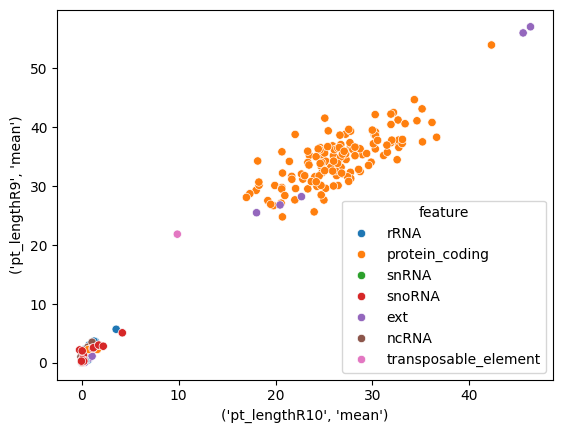

In [3]:
df["feature"] = [r.split('|')[-1] for r in df.index]; df.head()
sns.scatterplot(df, x=("pt_lengthR10", "mean"), y=("pt_lengthR9", "mean"), hue="feature")

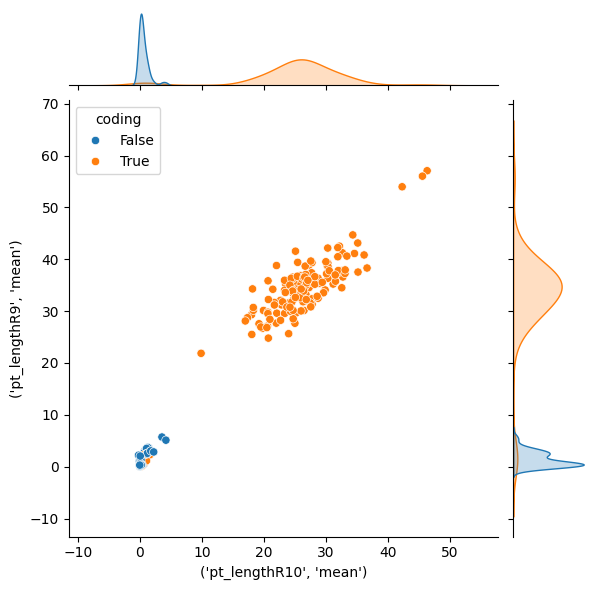

In [54]:
df["coding"] = df.feature.isin(('protein_coding', 'ext', 'transposable_element'))
g = sns.jointplot(df, x=("pt_lengthR10", "mean"), y=("pt_lengthR9", "mean"), hue="coding") # kind="reg"
fig = g.figure 
fig.savefig("R9_R10.yeast.joinplot.png")
fig.savefig("R9_R10.yeast.joinplot.pdf")

### boxplot

In [49]:
_cols =[("feature", ""), ( 'pt_lengthR9', 'mean'), ( 'pt_lengthR10', 'mean')]
_df = df.loc[~df.feature.isin(("ext", 'transposable_element')), _cols]
df3 = _df.melt("feature", col_level=0, var_name="sample", value_name="pt_len")
df3.loc[df3["sample"]=="pt_lengthR9", "sample"] = "R9"
df3.loc[df3["sample"]=="pt_lengthR10", "sample"] = "R10"
df3.head()

,feature,sample,pt_len
0,rRNA,R9,0.347460
1,rRNA,R9,5.721942
2,protein_coding,R9,36.505381
3,protein_coding,R9,33.993798
4,protein_coding,R9,31.609129


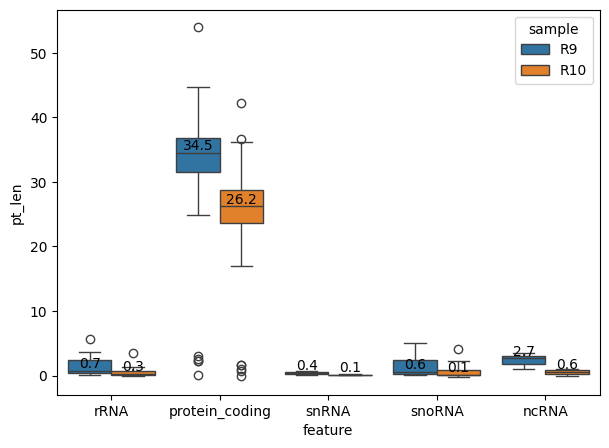

In [66]:
import matplotlib.patheffects as path_effects

def add_median_labels(ax: plt.Axes, fmt: str = ".1f") -> None:
    """Add text labels to the median lines of a seaborn boxplot.

    Args:
        ax: plt.Axes, e.g. the return value of sns.boxplot()
        fmt: format string for the median value
    """
    lines = ax.get_lines()
    boxes = [c for c in ax.get_children() if "Patch" in str(c)]
    start = 4
    if not boxes:  # seaborn v0.13 => fill=False => no patches => +1 line
        boxes = [c for c in ax.get_lines() if len(c.get_xdata()) == 5]
        start += 1
    lines_per_box = len(lines) // len(boxes)
    for median in lines[start::lines_per_box]:
        x, y = (data.mean() for data in median.get_data())
        # choose value depending on horizontal or vertical plot orientation
        value = x if len(set(median.get_xdata())) == 1 else y
        text = ax.text(x, y, f'{value:{fmt}}', ha='center', va='bottom') #, color='white', fontweight='bold'
        # create median-colored border around white text for contrast
        #text.set_path_effects([path_effects.Stroke(linewidth=3, foreground=median.get_color()), path_effects.Normal(),])


fig, ax = plt.subplots(figsize=(7, 5))
sns.boxplot(df3, x="feature", y="pt_len", hue="sample", ax=ax)
add_median_labels(ax)
fig.savefig("R9_R10.yeast.boxplot.png")
fig.savefig("R9_R10.yeast.boxplot.pdf")

In [57]:
medians = df3.groupby(['feature', 'sample'])['pt_len'].median(); medians

feature         sample
ncRNA           R10        0.630769
                R9         2.686486
protein_coding  R10       26.203571
                R9        34.543962
rRNA            R10        0.302381
                R9         0.710891
snRNA           R10        0.137049
                R9         0.421003
snoRNA          R10        0.116344
                R9         0.622159
Name: pt_len, dtype: float64

In [58]:
ax.get_xticks()

[0, 1, 2, 3, 4]

## comparison with tailfindR